# Máximo de una funcion

In [1]:
from math import sin, pi
from typing import Callable
import random
import matplotlib.pyplot as plt

Creamos una función que nos devuelve el valor de la función en un punto dado.

In [2]:
def f(x: int) -> float:
    """La función a ser maximizada"""
    return x * sin(10*pi*x) + 1

Para trabajar con cadenas de longitud 22 binarias, preferiremos esta vez usar listas en lugar de numpy.
Creamos una funcion que convierte de listas de 22 bits a su representación entera:

In [3]:
def decimal_de(cadena: list) -> float:
    """Da la representación decimal del gen"""
    num = 0
    for i in range(len(cadena) - 1, -1, -1):
        num += cadena[len(cadena) - 1 - i] * 2**i
    num = -1 + (3 / (2**22 - 1)) * num
    return num


In [4]:
# Prueba de funcionamiento:
import random
import timeit
cadena = [0,1,1,0,1,0,1,0,1,0,1,0,1,0,0,0,0,1,1,0,1,0]
#generar 50000 cadenas de 22 bits

# print(timeit.timeit(lambda: f(decimal_de(cadena)), number=10000000))

## Población inicial
Para crear una población escogemos que tenga 50 individuos, y para cada uno de ellos generamos una lista de 22 bits aleatorios.

In [5]:
INDIVIDUOS = 50

In [6]:
def crear_poblacion(tamano: int) -> list:
    """Crea una población de tamaño individuos para el problema de la maximización de la función aptitud."""
    poblacion = []
    for i in range(tamano):
        cadena = [random.randint(0, 1) for _ in range(22)]
        poblacion.append(cadena)
    return poblacion

In [7]:
poblacion = crear_poblacion(INDIVIDUOS)

## Función de evaluación
La aptitud será la función que queremos maximizar, pero hacemos una pequeña corrección para no trabajar con dos signos.

In [8]:
def aptitud_maximizar(individuo: list) -> float:
    """Aptitud de un individuo"""
    funcion = f(decimal_de(individuo))
    if funcion < 0:
        return 0
    else:
        return funcion

## Operadores genéticos

### Selección
Para seleccionar los padres usamos el método de la ruleta con pesos.

In [9]:
def seleccionar_ruleta(
    poblacion: list, n: int, fun_aptitud: Callable = aptitud_maximizar
) -> list:
    """Selecciona n individuos de la población usando el método de la ruleta.
    :param poblacion: matriz de individuos
    :param n: número de individuos a seleccionar
    :param fun_aptitud: función para calcular la aptitud de un individuo
    :return: matriz de individuos seleccionados"""

    aptitudes = [fun_aptitud(individuo) for individuo in poblacion]
    poblacion_seleccionada = []
    aptitudes_acumuladas = [sum(aptitudes[: i + 1]) for i in range(len(aptitudes))]
    aptitud_total = aptitudes_acumuladas[-1]

    # Para cada progenitor a seleccionar
    for _ in range(n):
        # Seleccionamos un numero decimal aleatorio entre 0 y la suma total de aptitudes
        valor = random.uniform(0, aptitud_total)

        seleccionado = 0

        while not aptitudes_acumuladas[seleccionado] >= valor:
            seleccionado += 1
        poblacion_seleccionada.append(poblacion[seleccionado])
    return poblacion_seleccionada

### Crossover

In [10]:
def crossover(
    progenitores: list,
    probabilidad: float = 1,
) -> list:
    """Produce 2 nuevos individuos a partir de crossover si la probabilidad lo permite. Si no se produce, se retornan los progenitores.
    :param progenitores: matriz de progenitores
    :return: matriz de individuos con los nuevos individuos"""

    if random.uniform(0, 1) <= probabilidad:
        # Me quedo con dos progenitores al azar
        progenitores = random.sample(list(progenitores), 2)
        # Elijo un punto de corte
        punto_corte = random.randint(1, len(progenitores[0]) - 1)
        # Creo a los hijos
        hijo1 = []
        hijo2 = []
        hijo1 = progenitores[0][:punto_corte] + progenitores[1][punto_corte:]
        hijo2 = progenitores[1][:punto_corte] + progenitores[0][punto_corte:]
        # Los devuelvo como ndarray
        return [hijo1, hijo2]
    else:
        return progenitores

### Mutación

In [11]:
def mutacion(individuo: list, probabilidad: float, max_genes_a_mutar: int = 1) -> None:
    """Realiza la mutación de un individuo con una probabilidad dada.
    :param individuo: lista que contiene los genes del individuo
    :param probabilidad: probabilidad de mutación"""
    if random.uniform(0, 1) <= probabilidad:
        num_genes_mutar = random.randint(0, max_genes_a_mutar)
        indices_a_mutar = random.sample(range(len(individuo)), num_genes_mutar)
        for i in indices_a_mutar:
            individuo[i] = random.choice([0, 1])

### Elitismo

In [12]:
def seleccion_elitista(
    poblacion: list, n: int, fun_aptitud: Callable = aptitud_maximizar
) -> list:
    """Selecciona a los n individuos más aptos de la población.
    :param poblacion: individuos de entre los que seleccionar
    :param n: número de individuos a seleccionar
    :param fun_aptitud: función para calcular la aptitud de un individuo
    :return: individuos seleccionados"""
    patata = sorted(poblacion, key=fun_aptitud, reverse=True)[:n]
    return patata

## Prueba de ejecución

Ejecución 0
####################
Generación: 200
Mejor aptitud: 2.850273610877346
Individuo: 1.850534403451539
Binario:  [1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1]
####################
Ejecución 1
####################
Generación: 200
Mejor aptitud: 2.850273717539224
Individuo: 1.8505401254988016
Binario:  [1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]
####################
Ejecución 2
####################
Generación: 200
Mejor aptitud: 2.8501756236709266
Individuo: 1.8502196908520916
Binario:  [1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]
####################
Ejecución 3
####################
Generación: 200
Mejor aptitud: 2.8502531041044143
Individuo: 1.8503970743172347
Binario:  [1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1]
####################
Ejecución 4
####################
Generación: 200
Mejor aptitud: 2.8484087006193324
Individuo: 1.8491181967540258
Binario:  [1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1,

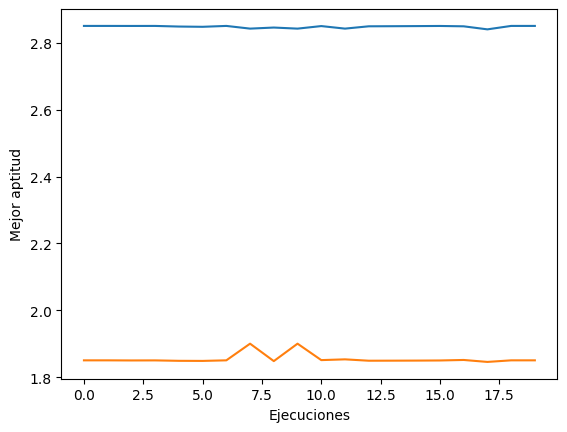

In [13]:
INDIVIDUOS = 50
PROB_CROSSOVER = 0.25
PROB_MUTACION = 0.01
GENERACIONES = 200
NUM_EJECUCIONES = 20


def ejecutar(INDIVIDUOS, PROB_CROSSOVER, PROB_MUTACION, GENERACIONES, poblacion=crear_poblacion(INDIVIDUOS)):
    mejores_aptitudes = []
    aptitudes_medias = []

    aptitudes_medias.append(
        sum([aptitud_maximizar(individuo) for individuo in poblacion]) / INDIVIDUOS
    )
    mejores_aptitudes.append(
        max([aptitud_maximizar(individuo) for individuo in poblacion])
    )

    for _ in range(GENERACIONES):
        aptitudes_medias.append(
            sum([aptitud_maximizar(individuo) for individuo in poblacion]) / INDIVIDUOS
        )
        mejores_aptitudes.append(
            max([aptitud_maximizar(individuo) for individuo in poblacion])
        )
        nueva_poblacion = []
        while len(nueva_poblacion) < INDIVIDUOS:
            seleccionados = seleccionar_ruleta(poblacion, 2)
            hijos = crossover(seleccionados, PROB_CROSSOVER)
            for hijo in hijos:
                mutacion(hijo, PROB_MUTACION)
                nueva_poblacion.append(hijo)
            for item in nueva_poblacion:
                poblacion.append(item)
        poblacion = seleccion_elitista(poblacion, INDIVIDUOS)
    print("####################")
    print(f"Generación: {GENERACIONES}")
    print(f"Mejor aptitud: {mejores_aptitudes[-1]}")
    print(
        f"Individuo: {decimal_de(sorted(poblacion, key=aptitud_maximizar, reverse=True)[0])}"
    )
    print("Binario: ", sorted(poblacion, key=aptitud_maximizar, reverse=True)[0])
    print("####################")
    
    return (
        max(mejores_aptitudes),
        decimal_de(sorted(poblacion, key=aptitud_maximizar, reverse=True)[0]),
        sorted(poblacion, key=aptitud_maximizar, reverse=True)[0],
    )


mejores_individuos = []
for i in range(NUM_EJECUCIONES):
    print(f"Ejecución {i}")
    mejores_individuos.append(ejecutar(INDIVIDUOS, PROB_CROSSOVER, PROB_MUTACION, GENERACIONES))
    
#Representamos los resultados con matplotlib, indicando en cada punto el valor de x
plt.plot([i[0] for i in mejores_individuos], label="Mejor aptitud")
plt.plot([i[1] for i in mejores_individuos], label="Valor de x")
plt.xlabel("Ejecuciones")
plt.ylabel("Mejor aptitud")
plt.show()